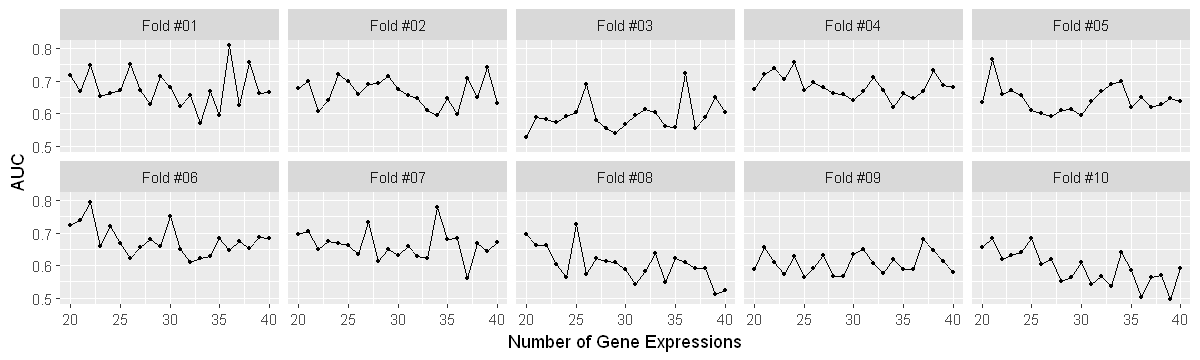

In [13]:
library(ggplot2)
library(repr)
options(repr.plot.width=10, repr.plot.height=3)
df <- read.table('output/result_10_fold.csv', sep=',', header=T)

p <- ggplot(df, aes(n_genes, auc_valid)) + 
    # geom_bar(stat='identity') + 
    geom_line(size=.1) + geom_point(size=.8) +
    facet_wrap(. ~ paste('Fold #', ifelse(fold < 10, paste('0', fold, sep=''), fold), sep=''), ncol=5) +
    xlab('Number of Gene Expressions') + ylab('AUC')

ggsave('images/result_10_fold_per_n_genes.pdf', p, units='cm', heigh=7, width=18)

p

In [2]:
df <- read.csv('output/fill/accuracy_fish_aucs.csv', sep=',')
df <- merge(aggregate(auc ~ var, df, mean), aggregate(auc ~ var, df, sd), by='var')
colnames(df) <- c('FISH', 'AUC (avg)', 'AUC (std)')
df

FISH,AUC (avg),AUC (std)
11p15,0.9161716,0.0196143552
13q14,0.9489554,0.0216616414
13q34,0.9548645,0.0125242543
15q15,0.9670555,0.0269665538
17p13,0.8552496,0.0181920570
19q13,0.9562469,0.0205047922
1q21,0.9358772,0.0185721794
20q13,0.8194801,0.1121443855
21q22,0.9465282,0.0347287794
3q21,0.9359223,0.0083408214


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


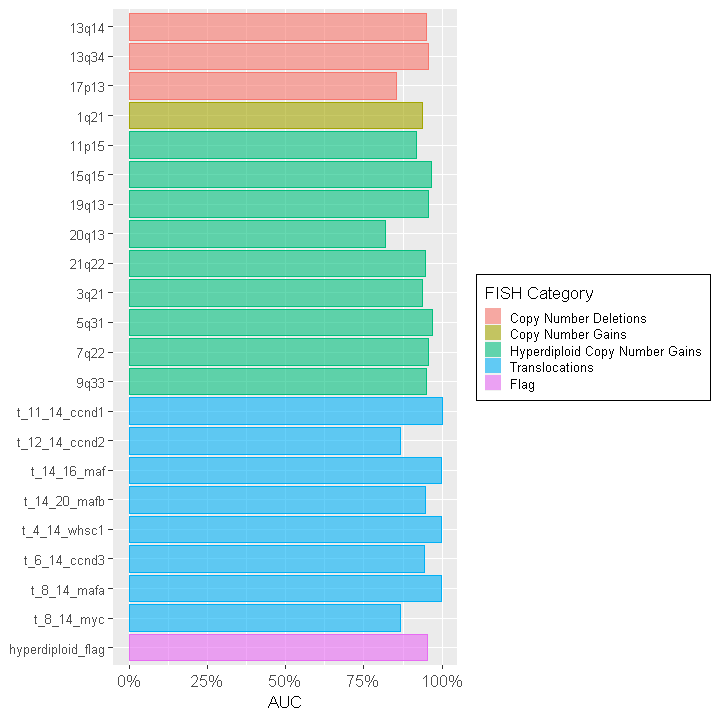

In [79]:
library(ggplot2)

df.base <- read.csv('output/fill/accuracy_fish_aucs.csv', sep=',')
df <- aggregate(auc ~ var, df.base, mean)

df <- df[match(unique(df.base$var), df$var),]

df$category <- c(rep('Copy Number Deletions', 3), c('Copy Number Gains'), rep('Hyperdiploid Copy Number Gains', 9), rep('Translocations', 8), c('Flag'))

fish.levels <- c("Copy Number Deletions", "Copy Number Gains", "Hyperdiploid Copy Number Gains", "Translocations", "Flag")
df$category <- factor(df$category, levels = fish.levels)
#df$category <- fish.levels
df <- df[order(df$category),]
# df$category <- factor(df$category, levels = fish.levels)

df$var <- factor(df$var, levels = df$var[rev(order(df$category))])

p <- ggplot(df, 
                aes(x = var, 
                    y = auc, 
                    colour = category,
                    fill = category)) + 
  geom_bar(stat = "identity", alpha = .6, size = 0.3) +
  ylim(0,1) + 
  scale_fill_hue(name    = 'FISH Category', 
                 labels  = fish.levels) +
  scale_colour_hue(guide = "none") +
  scale_y_continuous(labels = scales::percent) +
  xlab(NULL) + ylab("AUC") +
  theme(legend.background  = element_rect(colour = "black", size = .2),
        panel.grid.major.y = element_line(size = .15),
        text               = element_text(size = 10),
        legend.key.size    = unit(10, "pt"),
        legend.position    = 'right',
        axis.text.x        = element_text(size = 10),
        axis.title.x       = element_text(vjust = 1)) + 
  coord_flip()

options(repr.plot.width=6, repr.plot.height=6)

ggsave('images/fish_auc.pdf', p, units='cm', heigh=16, width=16)

p

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


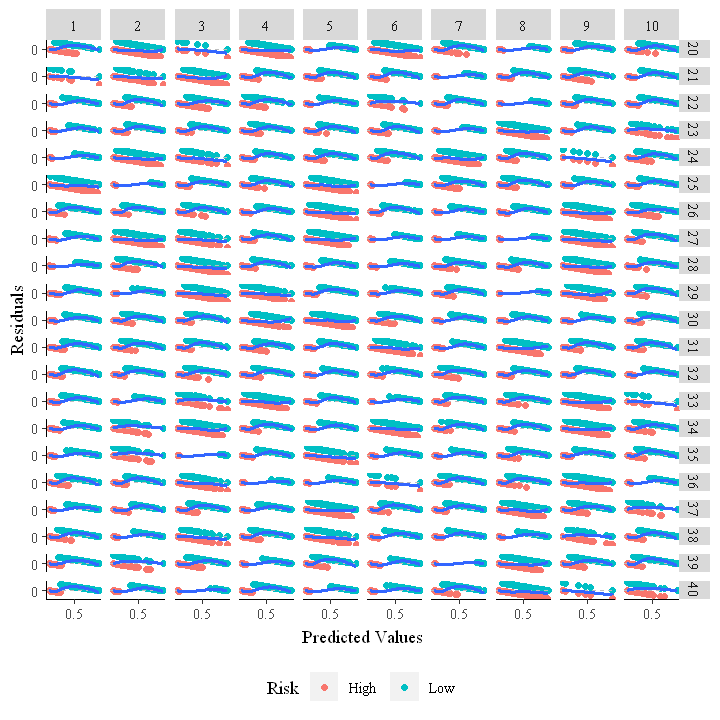

In [83]:
library(ggplot2)
library(dplyr)
library(MESS)

df <- read.csv('output/inference_train_10_fold.csv', sep=',')
colnames(df)[5] <- 'n_genes' 

df.limit <- read.csv('output/result_10_fold.csv', sep=',')
df.limit <- df.limit[c('fold', 'n_genes', 'y_train_hat_min', 'y_train_hat_max')]

df <- merge(df, df.limit, on=c('fold', 'n_genes'))

df$y_hat <- (df$y_hat - df$y_train_hat_min) / (df$y_train_hat_max - df$y_train_hat_min)

simple_roc <- function(labels, scores){
  labels <- labels[order(scores, decreasing=TRUE)]
  list(data.frame(TPR=cumsum(labels)/sum(labels), FPR=cumsum(!labels)/sum(!labels), labels))
}

p <- 
  ggplot(df, aes(y_hat, y_true - y_hat)) + geom_point(aes(colour=as.factor(y_true))) + ylim(-1, 1) + 
  geom_hline(yintercept = 0, lty=2,col="grey") + xlab('Predicted Values') + ylab('Residuals') + 
  geom_smooth() + theme(legend.position = 'bottom') + 
  scale_colour_discrete(name = "Risk", labels=c('High', 'Low')) +
  theme(text=element_text(size=11, family='serif'), legend.direction = "horizontal") +
  facet_grid(n_genes ~ fold) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black")) +
  scale_x_continuous(breaks=c(.5)) + scale_y_continuous(breaks=c(0)) 

ggsave('images/residuals.pdf', p, units='cm', heigh=28, width=18)

p

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


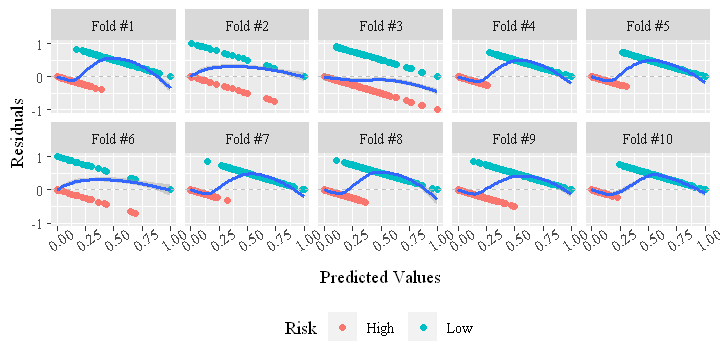

In [113]:
library(ggplot2)
library(dplyr)
library(MESS)

df <- read.csv('output/inference_train_10_fold.csv', sep=',')
colnames(df)[5] <- 'n_genes' 

df.limit <- read.csv('output/result_10_fold.csv', sep=',')
df.limit <- df.limit[c('fold', 'n_genes', 'y_train_hat_min', 'y_train_hat_max')]

df <- merge(df, df.limit, on=c('fold', 'n_genes'))

df <- merge(df, read.csv('output/best_result_per_10_fold.csv', sep=','), on=c('fold', 'n_genes'))[colnames(df)]

df$y_hat <- (df$y_hat - df$y_train_hat_min) / (df$y_train_hat_max - df$y_train_hat_min)

df$fold <- paste('Fold #', df$fold, sep='')
df$fold <- factor(df$fold, levels = unique(df$fold[order(as.numeric(gsub('Fold #', '', df$fold)))]))

simple_roc <- function(labels, scores){
  labels <- labels[order(scores, decreasing=TRUE)]
  list(data.frame(TPR=cumsum(labels)/sum(labels), FPR=cumsum(!labels)/sum(!labels), labels))
}

p <- 
  ggplot(df, aes(y_hat, y_true - y_hat)) + geom_point(aes(colour=as.factor(y_true))) + ylim(-1, 1) + 
  geom_hline(yintercept = 0, lty=2,col="grey") + xlab('Predicted Values') + ylab('Residuals') + 
  geom_smooth() + theme(legend.position = 'bottom') + 
  scale_colour_discrete(name = "Risk", labels=c('High', 'Low')) +
  theme(text=element_text(size=11, family='serif'), 
        legend.direction = "horizontal", 
        axis.text.x=element_text(angle=35)) +
  facet_wrap(. ~ fold, ncol=5) +
  scale_x_continuous(breaks=c(0, .25, .5, .75, 1)) + scale_y_continuous(breaks=c(-1, 0, 1)) 

ggsave('images/residuals_best_results.pdf', p, units='cm', heigh=8, width=18)

options(repr.plot.width=6, repr.plot.height=3)
p

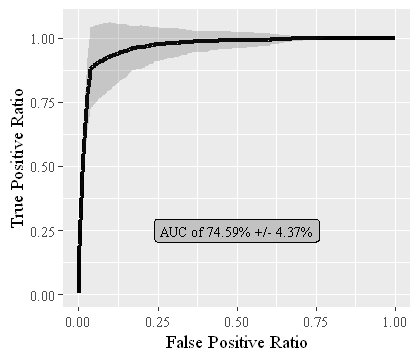

In [118]:
result <- 
  df %>%
    group_by(fold) %>%
    summarize(roc = simple_roc(y_true, y_hat))

final_df = data.frame()

for (i in result$roc) {
  
  i['INDEX'] = 1:nrow(i)
  
  final_df <- rbind(final_df, i)
}

final_df <- as.data.frame(cbind(aggregate(TPR ~ INDEX, final_df, mean)$TPR,
      aggregate(TPR ~ INDEX, final_df, sd)$TPR,
      aggregate(FPR ~ INDEX, final_df, mean)$FPR,
      aggregate(FPR ~ INDEX, final_df, sd)$FPR))

colnames(final_df) <- c('TPR.mean', 'TPR.sd', 'FPR.mean', 'FPR.sd')

p <- 
  ggplot(final_df, aes(FPR.mean, TPR.mean)) + geom_line(size=1.2) + 
  geom_ribbon(aes(x=FPR.mean, ymax=TPR.mean + TPR.sd, ymin=TPR.mean - TPR.sd), alpha=0.2) +
  xlab('False Positive Ratio') + ylab('True Positive Ratio') +
  geom_label(aes(label='AUC of 74.59% +/- 4.37%'), x=.5, y=.25, size=3, family='serif', fill = "gray", alpha=.1) +
  theme(text=element_text(size=11, family='serif'))

ggsave('images/roc_curve_best_results.pdf', p, units='cm', heigh=7, width=8)

options(repr.plot.width=3.5, repr.plot.height=3)
p